<a href="https://colab.research.google.com/github/Orange-yy/ML2021/blob/main/%E2%80%9CML2021Spring_HW1_ipynb%E2%80%9D%EF%BC%88%E6%94%B9%E8%BF%9B%E7%89%88%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [ ]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 9.33MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 3.98MB/s]


# **Import Some Packages**

In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#下面三个包是新增的
from sklearn.model_selection import train_test_split
import pandas as pd
import pprint as pp

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Data Analysis**
可视化数据，筛选有用特征

In [ ]:
data_tr = pd.read_csv(tr_path) #读取训练数据
data_tt = pd.read_csv(tt_path) #读取测试数据
data_tr.head(3) #数据量很大，看前三行就行，大致浏览下数据类型

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,...,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.000647,53.439316,43.279629,19.586492,0.838995,0.807766,25.679101,21.280270,84.005294,13.467716,36.637887,63.318650,23.688882,44.385166,16.463551,1.664819,15.299228,12.051505,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.552264,53.256795,43.622728,20.151838,0.897801,0.887893,26.060544,21.503832,84.438618,13.038611,36.429119,62.434539,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.702086,53.991549,43.604229,20.704935,0.972842,0.965496,25.754087,21.016210,84.133873,12.581952,36.416557,62.024517,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911,0.955306,0.963079,25.947015,20.941798,83.995931,12.938675,37.014578,62.116843,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656


In [ ]:
data_tt.head(3)

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,ID,IL,IN,IA,KS,KY,LA,MD,MA,MI,MN,MS,MO,NE,NV,NJ,NM,NY,NC,OH,OK,OR,PA,RI,SC,TX,UT,VA,WA,WV,...,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.382281,24.030140,66.747591,44.678740,22.055633,1.257046,1.302953,35.888346,30.847431,93.212831,3.840129,29.313604,51.933738,8.666508,29.870293,5.531424,2.634617,19.704998,13.532732,24.450491,65.790844,44.846171,21.029253,1.055138,1.102237,35.007218,30.230430,93.261010,3.875565,29.249223,52.071090,8.624001,29.374792,5.391413,2.754804,19.695098,13.685645,24.747837,66.194950,44.873473
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.260055,24.656120,56.102288,38.729149,2.331589,0.417591,0.417591,12.997859,9.114625,88.742332,7.038933,29.819088,59.109292,21.473941,41.384746,9.226583,3.138238,22.481708,17.635395,23.832616,55.692361,38.756539,2.011478,0.413432,0.413432,13.408644,9.240964,89.177999,6.903325,30.309182,58.742461,21.720187,41.375784,9.450179,3.150088,22.075715,17.302077,23.559622,57.015009,38.372829
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.377685,26.159011,54.357669,39.335294,1.658765,0.450383,0.430983,13.254896,8.767861,89.109790,6.754043,27.881581,58.287380,19.698013,39.292417,8.563846,2.846935,24.362498,18.798445,25.657059,55.069605,39.451691,2.163458,0.428718,0.440211,12.983094,8.577449,88.323581,7.016447,28.660016,59.109045,20.123959,40.072556,8.781522,2.888209,23.920870,18.342506,24.993341,55.291498,38.907257


In [ ]:
data_tr.columns #查看有多少列特征

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

In [ ]:
data_tr.drop(['id'],axis = 1, inplace = True) #由于id列用不到，删除id列
data_tt.drop(['id'],axis = 1, inplace = True)

In [ ]:
cols = list(data_tr.columns)  #拿到特征列名称
pp.pprint(data_tr.columns)

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli',
       'wearing_mask', 'travel_outside_state', 'work_outside_home', 'shop',
       'restaurant', 'spent_time', 'large_event', 'public_transit', 'anxious',
       'depressed', 'felt_isolated', 'worried_become_ill', 'worried_finances',
       'tested_positive', 'cli.1', 'ili.1', 'hh_cmnty_cli.1',
       'nohh_cmnty_cli.1', 'wearing_mask.1', 'travel_outside_state.1',
       'work_outside_home.1', 'shop.1', 'restaurant.1', 'spent_time.1',
       'large_event.1', 'public_transit.1', 'anxious.1', 'depressed.1',
       'felt_isolated.1', 'worried_become_ill.1', 'worried_finances.1',
       'tested_positive.1', 'cli.2', 'ili.2', 'hh_cmnty_cli.2',
       'nohh_cmnty_cli.2', 'wearing_m

In [ ]:
pp.pprint(data_tr.info()) #看每列数据类型和大小

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AL                      2700 non-null   float64
 1   AK                      2700 non-null   float64
 2   AZ                      2700 non-null   float64
 3   AR                      2700 non-null   float64
 4   CA                      2700 non-null   float64
 5   CO                      2700 non-null   float64
 6   CT                      2700 non-null   float64
 7   FL                      2700 non-null   float64
 8   GA                      2700 non-null   float64
 9   ID                      2700 non-null   float64
 10  IL                      2700 non-null   float64
 11  IN                      2700 non-null   float64
 12  IA                      2700 non-null   float64
 13  KS                      2700 non-null   float64
 14  KY                      2700 non-null   

In [ ]:
WI_index = cols.index('WI')  # WI列是states one-hot编码最后一列，取值为0或1，后面特征分析时需要把states特征删掉
WI_index #wi列索引

39

In [ ]:
data_tr.iloc[:, 40:].describe() #从上面可以看出wi 列后面是cli, 所以列索引从40开始， 并查看这些数据分布

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,10.352273,2.393285,18.074684,13.075498,19.213321,64.633769,44.519474,16.300893,0.994568,1.019135,29.529305,24.402875,89.736737,8.861371,31.664651,55.198075,16.635440,36.176886,10.304595,2.389372,18.071667,13.067127,19.228457,64.734139,44.544124,16.366695,0.997986,1.022472,29.610807,24.477913,89.790227,8.830759,31.624272,55.119903,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,4.698705,1.053270,2.248750,1.621328,2.706605,6.232239,5.265787,7.637823,0.420114,0.423538,9.082940,8.443146,5.366067,3.389310,4.916168,4.524887,5.660085,6.664218,4.692479,1.053237,2.249864,1.625269,2.707148,6.226622,5.248787,7.627538,0.420205,0.423705,9.070537,8.437044,5.351574,3.377722,4.901857,4.524442,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708,0.126321,0.132470,9.961640,6.857181,72.330064,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708,0.126321,0.132470,9.961640,6.857181,72.356322,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,6.653427,1.720601,16.420485,11.943953,17.292063,59.529326,40.520369,10.200722,0.676205,0.699773,23.264324,18.607342,86.386111,6.168986,28.202745,51.403036,13.248788,30.646955,6.605724,1.715372,16.423140,11.933745,17.303887,59.703583,40.533768,10.251453,0.680065,0.703390,23.307794,18.644297,86.436468,6.159286,28.187875,51.262363,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,9.802380,2.204258,17.685476,12.963659,18.735807,65.688024,43.911769,15.479766,0.917343,0.942587,29.061296,23.905188,90.859943,8.274067,32.108420,55.129326,16.293314,36.169954,9.738629,2.203602,17.684970,12.956723,18.745824,65.783579,43.947131,15.572281,0.920815,0.948001,29.137273,24.010817,90.912271,8.251691,32.051128,54.990445,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932258,43.997637,15.646480


In [ ]:
data_tt.iloc[:, 40:].describe() #查看测试集数据分布，并和训练集数据分布对比，两者特征之间数据分布差异不是很大

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,0.972457,0.991809,29.075682,24.018729,89.637506,9.001325,31.620607,55.422982,16.554387,36.371653,10.356177,2.382769,18.030215,13.020293,19.230715,64.406944,44.379019,15.976544,0.977508,0.997195,29.133016,24.076375,89.715077,8.955668,31.541307,55.360132,16.510614,36.268780,10.309059,2.376621,18.013300,13.007566,19.220921,64.527609,44.386619,15.989196,0.981119,1.000032,29.192015,24.117403,89.765373,8.917700,31.513665,55.268628,16.444916,36.165898,10.248975,2.369115,17.988147,12.993830,19.238723,64.619920,44.411505
std,0.411997,0.415468,9.596290,8.988245,4.733549,3.655616,4.754570,4.366780,5.688802,6.203232,4.521531,1.114568,2.235211,1.715389,2.689158,5.721753,4.579553,7.813659,0.413665,0.418835,9.527793,8.920860,4.708376,3.651532,4.734470,4.374390,5.686128,6.195079,4.508985,1.119861,2.210427,1.705901,2.674568,5.694758,4.612057,7.786780,0.413244,0.418081,9.467570,8.865726,4.692231,3.637221,4.733639,4.350540,5.656828,6.192274,4.498845,1.114366,2.207022,1.713143,2.687435,5.685865,4.605268
min,0.139558,0.159477,9.171315,6.014740,76.895278,2.062500,18.299198,44.062442,3.800684,21.487077,2.324264,0.785854,12.853772,8.453722,13.269686,50.303447,35.432447,1.339310,0.152059,0.166967,9.207952,5.750693,76.895363,2.009744,18.154712,45.209752,3.549729,21.337579,2.285853,0.839549,12.968745,8.491336,13.177680,49.993134,34.663854,1.351363,0.049938,0.065544,9.459442,6.034050,77.025654,2.000000,18.278377,44.671891,3.837441,21.338425,2.334654,0.873986,12.696977,8.462444,13.476209,50.212234,35.072577
25%,0.673327,0.689367,21.831730,17.385490,86.587475,7.055039,28.755178,51.726987,13.314242,31.427591,6.832898,1.786206,16.463262,11.800174,17.164105,60.070159,40.683578,9.982916,0.667296,0.684726,21.967645,17.602241,86.761239,7.043880,28.713787,51.686774,13.275460,31.324347,6.890855,1.775599,16.502816,11.806194,17.101370,60.267099,40.912076,10.070058,0.677422,0.691911,22.145670,17.687770,86.799638,6.908287,28.730951,51.594301,13.391769,31.330469,6.802860,1.760374,16.406397,11.777101,17.197313,60.358203,40.910546
50%,0.925230,0.936610,28.183014,23.035749,90.123133,8.773243,31.826385,55.750887,17.100556,36.692799,9.734692,2.173884,17.750598,12.819747,19.154800,64.744199,44.459526,15.435832,0.919533,0.944818,28.177370,23.094211,90.142711,8.727310,31.647384,55.784308,17.064074,36.405847,9.712576,2.155570,17.783846,12.824065,19.094616,64.967013,44.485451,15.381420,0.931789,0.944038,28.137863,23.116177,90.182055,8.682130,31.525946,55.490325,16.975410,36.213594,9.550393,2.146468,17.719760,12.805424,19.068658,65.148128,44.504010
75%,1.251219,1.267463,36.813772,31.141866,93.387952,10.452262,35.184926,59.185350,20.919961,41.265159,13.637503,2.650302,19.455838,1

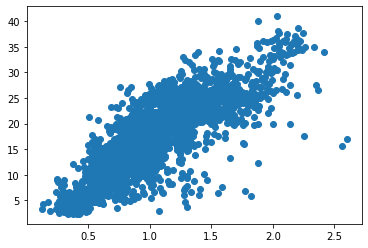

In [ ]:
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'tested_positive.2']) #肉眼分析cli特征与目标之间相关性

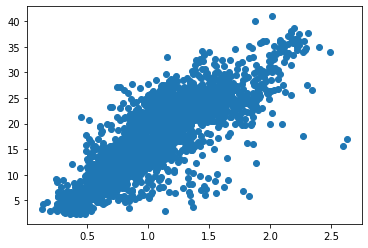

In [ ]:
plt.scatter(data_tr.loc[:, 'ili'], data_tr.loc[:, 'tested_positive.2'])

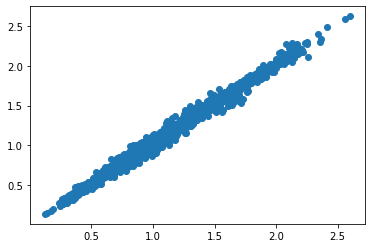

In [ ]:
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'ili'])  #cli 和ili两者差不多，所以这两个特征用一个就行

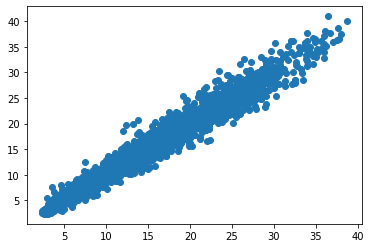

In [ ]:
plt.scatter(data_tr.loc[:,  'tested_positive'], data_tr.loc[:, 'tested_positive.2']) #day1 目标值与day3目标值相关性，线性相关的

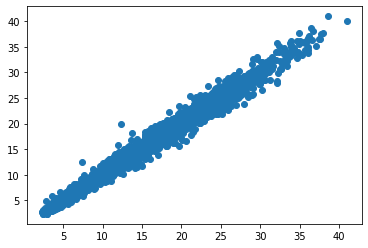

In [ ]:
plt.scatter(data_tr.loc[:,  'tested_positive.1'], data_tr.loc[:, 'tested_positive.2']) #day2 目标值与day3目标值相关性，线性相关的

In [ ]:
data_tr.iloc[:, 40:].corr() #上面手动分析太累，还是利用corr方法自动分析

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
cli,1.000000,0.995735,0.893416,0.882322,-0.107406,-0.095964,0.087305,-0.364165,-0.143318,-0.209020,-0.042033,-0.367103,0.273874,0.098033,0.100928,0.218502,0.537608,0.839122,0.980379,0.976171,0.896211,0.885178,-0.101056,-0.097092,0.087080,-0.367850,-0.147491,-0.216168,-0.051724,-0.371063,0.256712,0.088676,0.099487,0.223326,0.543373,0.839929,0.957059,0.952707,0.898067,0.887103,-0.094664,-0.097903,0.085913,-0.370197,-0.151291,-0.222834,-0.060308,-0.374071,0.237135,0.081456,0.098345,0.228750,0.550564,0.838504
ili,0.995735,1.000000,0.889729,0.878280,-0.109015,-0.106934,0.086355,-0.357443,-0.142082,-0.207210,-0.043535,-0.356652,0.281974,0.102715,0.107079,0.212931,0.532217,0.829756,0.977225,0.980473,0.892667,0.881292,-0.102606,-0.107662,0.085966,-0.361304,-0.146353,-0.214354,-0.052961,-0.360574,0.264872,0.093371,0.105446,0.217739,0.537874,0.831129,0.954996,0.956979,0.894564,0.883263,-0.096315,-0.107903,0.084708,-0.363795,-0.150141,-0.220942,-0.061298,-0.363873,0.245228,0.086229,0.104250,0.222909,0.544776,0.830527
hh_cmnty_cli,0.893416,0.889729,1.000000,0.997225,-0.035441,-0.069595,0.079219,-0.472746,-0.247043,-0.293775,-0.124151,-0.432142,0.336748,0.184739,0.198176,0.344457,0.552431,0.880187,0.887944,0.884020,0.998356,0.995176,-0.030237,-0.069270,0.074972,-0.474799,-0.250349,-0.297071,-0.130729,-0.432765,0.323053,0.182383,0.201034,0.347562,0.557364,0.880416,0.881768,0.877550,0.995396,0.991738,-0.025367,-0.069043,0.069933,-0.476538,-0.253615,-0.300062,-0.136937,-0.433276,0.307581,0.181497,0.203577,0.350255,0.561942,0.879724
nohh_cmnty_cli,0.882322,0.878280,0.997225,1.000000,-0.046063,-0.061914,0.097756,-0.465374,-0.238106,-0.280916,-0.116761,-0.423773,0.344074,0.190062,0.197661,0.340192,0.524022,0.869674,0.877606,0.873424,0.996165,0.998259,-0.040738,-0.062039,0.093529,-0.467316,-0.241687,-0.284398,-0.123252,-0.424445,0.331791,0.188544,0.200843,0.343024,0.529514,0.870315,0.872292,0.867896,0.993750,0.995093,-0.035759,-0.062137,0.088394,-0.469026,-0.245265,-0.287482,-0.129474,-0.424996,0.317836,0.188467,0.203599,0.345448,0.534711,0.869938
wearing_mask,-0.107406,-0.109015,-0.035441,-0.046063,1.000000,-0.220808,-0.735649,-0.691597,-0.788714,-0.807623,-0.894970,0.131350,0.232620,-0.070022,0.422058,0.843990,0.354130,-0.049350,-0.121569,-0.123680,-0.046423,-0.056529,0.998287,-0.220442,-0.737554,-0.688627,-0.787245,-0.805468,-0.892267,0.132301,0.217574,-0.069369,0.424822,0.842499,0.347359,-0.059477,-0.135146,-0.137841,-0.058149,-0.067698,0.995953,-0.219916,-0.739112,-0.685437,-0.785281,-0.802659,-0.889021,0.133487,0.204031,-0.067720,0.427533,0.840528,0.340101,-0.069531
travel_outside_state,-0.095964,-0.106934,-0.069595,-0.061914,-0.220808,1.000000,0.264107,0.256911,0.288473,0.349829,0.324270,-0.198308,-0.023175,0.058548,-0.376858,-0.136811,-0.096444,-0.113726,-0.091186,-0.102645,-0.063619,-0.055823,-0.220397,0.995838,0.268864,0.252461,0.288160,0.343854,0.322149,-0.201241,-0.011044,0.061782,-0.374146,-0.134507,-0.094679,-0.105467,-0.086332,-0.097991,-0.057164,-0.049281,-0.219423,0.989310,0.275348,0.249670,0.288098,0.336937,0.319736,-0.203611,0.001592,0.064425,-0.370776,-0.131961,-0.093096,-0.097303
work_outside_home,0.087305,0.086355,0.079219,0.097756,-0.735649,0.264107,1.000000,0.631958,0.743673,0.698047,0.

In [ ]:
#锁定上面相关性矩阵最后一列，也就是目标值列，每行是与其相关性大小
data_corr = data_tr.iloc[:, 40:].corr()
target_col = data_corr['tested_positive.2']
target_col

cli                       0.838504
ili                       0.830527
hh_cmnty_cli              0.879724
nohh_cmnty_cli            0.869938
wearing_mask             -0.069531
travel_outside_state     -0.097303
work_outside_home         0.034865
shop                     -0.410430
restaurant               -0.157945
spent_time               -0.252125
large_event              -0.052473
public_transit           -0.448360
anxious                   0.173295
depressed                 0.037689
felt_isolated             0.082182
worried_become_ill        0.262211
worried_finances          0.475462
tested_positive           0.981165
cli.1                     0.838224
ili.1                     0.829200
hh_cmnty_cli.1            0.879438
nohh_cmnty_cli.1          0.869278
wearing_mask.1           -0.065600
travel_outside_state.1   -0.100407
work_outside_home.1       0.037930
shop.1                   -0.412705
restaurant.1             -0.159121
spent_time.1             -0.255714
large_event.1       

In [ ]:
feature = target_col[target_col > 0.8] #在最后一列相关性数据中选择大于0.8的行，这个0.8是自己设的超参，大家可以根据实际情况调节
feature

cli                  0.838504
ili                  0.830527
hh_cmnty_cli         0.879724
nohh_cmnty_cli       0.869938
tested_positive      0.981165
cli.1                0.838224
ili.1                0.829200
hh_cmnty_cli.1       0.879438
nohh_cmnty_cli.1     0.869278
tested_positive.1    0.991012
cli.2                0.835751
ili.2                0.826075
hh_cmnty_cli.2       0.878218
nohh_cmnty_cli.2     0.867535
tested_positive.2    1.000000
Name: tested_positive.2, dtype: float64

In [ ]:
feature_cols = feature.index.tolist()  #将选择特征名称拿出来
feature_cols.pop() #去掉test_positive标签
pp.pprint(feature_cols) #得到每个需要特征名称列表

['cli',
 'ili',
 'hh_cmnty_cli',
 'nohh_cmnty_cli',
 'tested_positive',
 'cli.1',
 'ili.1',
 'hh_cmnty_cli.1',
 'nohh_cmnty_cli.1',
 'tested_positive.1',
 'cli.2',
 'ili.2',
 'hh_cmnty_cli.2',
 'nohh_cmnty_cli.2']


In [ ]:
feats_selected = [cols.index(col) for col in feature_cols]  #获取该特征对应列索引编号，后续就可以用feats + feats_selected作为特征值
feats_selected

[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

# **Some Utilities**

You do not need to modify this part.

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

# 新段落

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [ ]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mu,      #mu,std是自己加，baseline代码归一化有问题，重写归一化部分
                 std,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float) #去掉表头行和id列
        
        if not target_only:
            feats = list(range(93))#target_only 默认是false, 所以用的是全量特征，如果要用自己选择特征，则实例化这个类的时候，设置成True
        else:
            # TODO: Using 40 states & 4 tested_positive features (indices = 57 & 75)
            feats = list(range(40)) + feats_selected   # feats_selected是我们选择特征, 40代表是states特征
            
            #如果用只用两个特征，可以忽略前面数据分析过程,直接这样写
            #feats = list(range(40)) + [57, 75]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
     #       if mode == 'train':
     #           indices = [i for i in range(len(data)) if i % 10 != 0]
     #       elif mode == 'dev':
     #           indices = [i for i in range(len(data)) if i % 10 == 0]

            #baseline上面这段代码划分训练集和测试集按照顺序选择数据，可能造成数据分布问题，我改成随机选择
            indices_tr, indices_dev = train_test_split([i for i in range(data.shape[0])], test_size = 0.1, random_state = 0)
            if self.mode == 'train':
                indices = indices_tr
            elif self.mode == 'dev':
                indices = indices_dev

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
     #   self.data[:, 40:] = \
     #       (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
     #       / self.data[:, 40:].std(dim=0, keepdim=True)
 
        #baseline这段代码数据归一化用的是当前数据归一化
        #事实上验证集上和测试集上归一化一般只能用过去数据即训练集上均值和方差进行归一化     
        if self.mode == "train": 
          #如果是训练集，均值和方差用自己数据
            self.mu = self.data[:, 40:].mean(dim=0, keepdim=True)
            self.std = self.data[:, 40:].std(dim=0, keepdim=True)
        else: 
          #测试集和开发集，传进来的均值和方差是来自训练集保存，如何保存均值和方差，看数据dataload部分
            self.mu = mu
            self.std = std
            
        self.data[:,40:] = (self.data[:, 40:] - self.mu) / self.std  #归一化
        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [ ]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, mu=None, std=None):
    #训练集不需要传mu,std, 所以默认值设置为None
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mu, std, mode=mode, target_only=target_only)  # Construct dataset
    if mode == 'train':  #如果是训练集，把训练集上均值和方差保存下来
        mu = dataset.mu
        std = dataset.std
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader, mu, std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [ ]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),  #70是我调得最好的， 而且加层很容易过拟和
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        eps = 1e-6
        l2_reg = 0
        alpha = 0.0001
        #这段代码是l2正则，但是实际操作l2正则效果不好，大家也也可以调，把下面这段代码取消注释就行
#         for name, w in self.net.named_parameters():
#             if 'weight'  in name:
#                 l2_reg += alpha * torch.norm(w, p = 2).to(device)
        return torch.sqrt(self.criterion(pred, target) + eps) + l2_reg   
        #lr_reg=0, 上面这段代码用的是均方根误差torch.sqrt()，均方根误差和kaggle评测指标一致，而且训练模型也更平稳

# **Train/Dev/Test**

## **Training**

In [ ]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [ ]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [ ]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [ ]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
#target_only = False  ## TODO: Using 40 states & 2 tested_positive features
target_only = True   # 使用自己的特征，如果设置成False，用的是全量特征

# TODO: How to tune these hyper-parameters to improve your model's performance?
# 这里没调
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD 可换成adam试试
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [ ]:
tr_set, tr_mu, tr_std = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set, mu_none, std_none = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only, mu=tr_mu, std=tr_std)
tt_set, mu_none, std_none = prep_dataloader(tr_path, 'test', config['batch_size'], target_only=target_only, mu=tr_mu, std=tr_std)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 54)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 54)
Finished reading the test set of COVID19 Dataset (2700 samples found, each dim = 54)


In [ ]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [ ]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.6936)
Saving model (epoch =    2, loss = 17.5330)
Saving model (epoch =    3, loss = 17.3351)
Saving model (epoch =    4, loss = 17.1061)
Saving model (epoch =    5, loss = 16.8355)
Saving model (epoch =    6, loss = 16.5097)
Saving model (epoch =    7, loss = 16.1022)
Saving model (epoch =    8, loss = 15.5854)
Saving model (epoch =    9, loss = 14.9349)
Saving model (epoch =   10, loss = 14.1227)
Saving model (epoch =   11, loss = 13.1496)
Saving model (epoch =   12, loss = 12.0869)
Saving model (epoch =   13, loss = 11.0465)
Saving model (epoch =   14, loss = 10.2609)
Saving model (epoch =   15, loss = 9.7964)
Saving model (epoch =   16, loss = 9.5256)
Saving model (epoch =   17, loss = 9.3033)
Saving model (epoch =   18, loss = 9.0832)
Saving model (epoch =   19, loss = 8.8589)
Saving model (epoch =   20, loss = 8.6191)
Saving model (epoch =   21, loss = 8.3582)
Saving model (epoch =   22, loss = 8.0935)
Saving model (epoch =   23, loss = 7.833

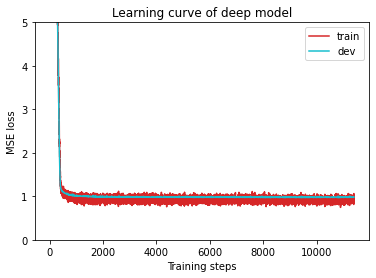

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

In [ ]:
dev(dv_set, model, device)  #验证集损失

0.9853214025497437

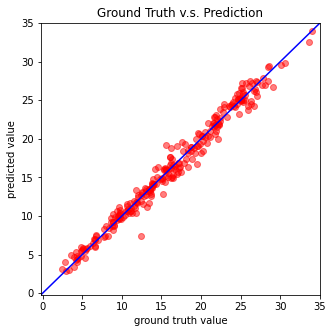

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [ ]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **总结**
这个case由于数据量比较小，训练数据与测试数据分布基本一致，而且每列数据的值都是百分数，所以特征之间数据分布差异不是很大，导致数据做完归一化效果也没有多大提升。原文数据归一化方法有问题，我改过以后效果也没有提升。其它超参数如增加层，节点，修改激活函数对结果提升也不是很明显， 提升比较显著的是特征筛选。simple baseline 用了93个特征，通过数据分析，我用了52个特征，一下就过了medium baseline, 然后微调了下训练集和验证集数据划分方式为随机选择，比例为7：3（在现在的代码里没改还是10%的验证），结果一下接近了strong baseline。simple baseline 损失函数均方方差，我改为均方根误差，模型训练收敛比较快，而且loss下降比较平稳，均方误差训练震荡比较大。最后试图用了l2正则，但训练集上效果反而不是很高，所以把l2去掉。除了以上trick,大家还可以尝试修改优化方法，比如adam, kfold等。

# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
